In [1]:
from pathlib import Path
import os
os.environ["VRE_LOGLEVEL"] = "0"
from pprint import pprint
import subprocess
from omegaconf import OmegaConf
from vre.representations import build_representations_from_cfg, ReprOut, Representation
from vre.readers import MultiTaskDataset
from vre.utils import reorder_dict, collage_fn, image_add_title
from semantic_mapper import get_new_semantic_mapped_tasks

import numpy as np
import torch as tr
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Some utils functions for plotting

In [2]:
def vre_plot_fn(rgb: tr.Tensor, x: tr.Tensor, node: Representation) -> np.ndarray:
    rgb, x = rgb.cpu().detach().numpy(), x.cpu().detach().numpy()
    node.data = ReprOut(rgb[None], x[None], [0])
    res = node.make_images()[0]
    return res

def plot_one(data: "MultiTaskItem", title: str, order: list[str],
             name_to_task: dict[str, Representation]) -> np.ndarray:
    img_data = {k: vre_plot_fn(data["rgb"], v, name_to_task[k]) for k, v in data.items()}
    img_data = reorder_dict(img_data, order)
    titles = [title if len(title) < 40 else f"{title[0:19]}..{title[-19:]}" for title in img_data]
    collage = collage_fn(list(img_data.values()), titles=titles, size_px=40)
    collage = image_add_title(collage, title, size_px=55, top_padding=110)
    return collage

#### Define the data path.
It can be a normal video (mp4) or a previous export of VRE if it contains the 6 relevant 'seed' experts:
- rgb
- opticalflow_rife
- depth_marigold
- normals_svd(depth_marigold)
- semantic_mask2former_mapillary_49189528_0
- semantic_mask2former_coco_47429163_0

You can also generate it using `vre /path/to/video.mp4 -o out_dir --config_path cfg.yaml`

In [3]:
cfg_path = Path.cwd() / "cfg.yaml"
data_path = Path.cwd() / "../../resources/test_video.mp4" # It can also be a previously exported VRE dir
vre_dir = data_path
if data_path.suffix == ".mp4":
    vre_dir = Path.cwd() / f"data_{data_path.name}"
    if not vre_dir.exists():
        subprocess.run(args=["vre", str(data_path), "--cfg_path", str(cfg_path),
                             "-o", str(vre_dir), "--frames", "1", "5", "100"],
                        env={**os.environ.copy(), **{"VRE_DEVICE": "cuda" if tr.cuda.is_available() else "cpu"}})
    else:
        print(f"Out dir '{vre_dir}' exists. Remove it first")


[2024-11-13T14:32:14 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] Building 'optical-flow/rife' (vre name: opticalflow_rife) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:15 VRE-INFO] [VRERuntime

     depth_marigold  ...  normals_svd(depth_marigold)
1          7.963324  ...                     4.033483
5          1.381312  ...                     3.320545
100        1.538141  ...                     3.718576

[3 rows x 6 columns]


#### Instantiate the MultiTaskDataset object

This is only done for the initial seed expert tasks defined earlier. We'll also plot them.

[2024-11-13T14:32:58 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Building 'optical-flow/rife' (vre name: opticalflow_rife) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:32:59 VRE-INFO] Tasks used 

[MultiTaskDataset]
 - Path: '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/data_test_video.mp4'
 - Tasks (6): [Marigold(depth_marigold ['depth_marigold']), DepthNormalsSVD(normals_svd(depth_marigold) ['normals_svd(depth_marigold)']), FlowRife(opticalflow_rife ['opticalflow_rife']), RGB(rgb ['rgb']), Mask2Former(semantic_mask2former_coco_47429163_0 ['semantic_mask2former_coco_47429163_0']), Mask2Former(semantic_mask2former_mapillary_49189528_0 ['semantic_mask2former_mapillary_49189528_0'])]
 - Length: 3
 - Handle missing data mode: 'fill_nan'
 - Normalization: '{'depth_marigold': 'min_max', 'normals_svd(depth_marigold)': 'min_max', 'opticalflow_rife': 'min_max', 'rgb': 'min_max', 'semantic_mask2former_coco_47429163_0': 'min_max', 'semantic_mask2former_mapillary_49189528_0': 'min_max'}'
== Shapes ==
{'depth_marigold': (540, 960),
 'normals_svd(depth_marigold)': (540, 960, 3),
 'opticalflow_rife': (540, 960, 2),
 'rgb': (540, 960, 3),
 'semantic_mask2former_

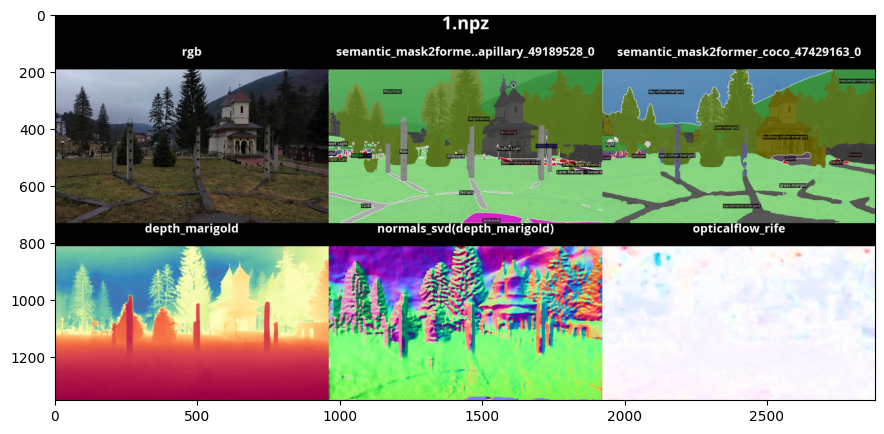

In [4]:
INCLUDE_SEMANTICS_ORIGINAL = True
task_names = ["rgb", "depth_marigold", "normals_svd(depth_marigold)", "opticalflow_rife"]
order = ["rgb", "depth_marigold", "normals_svd(depth_marigold)"]
if INCLUDE_SEMANTICS_ORIGINAL:
    task_names.extend(["semantic_mask2former_coco_47429163_0", "semantic_mask2former_mapillary_49189528_0"])
    order = ["rgb", "semantic_mask2former_mapillary_49189528_0", "semantic_mask2former_coco_47429163_0",
             "depth_marigold", "normals_svd(depth_marigold)"]

representations = build_representations_from_cfg(OmegaConf.load(cfg_path))
reader = MultiTaskDataset(vre_dir, task_names=task_names,
                          task_types=representations, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)
orig_task_names = list(reader.task_types.keys())

print(reader)
print("== Shapes ==")
pprint(reader.data_shape)

data, name, _ = reader[np.random.randint(0, len(reader))]
collage = plot_one(data, title=name, order=order, name_to_task=reader.name_to_task)
plt.figure(figsize=(15, 5))
plt.imshow(collage)
plt.show()


#### Add the newly defined tasks

Thery are read from `semantic_mapper.py` but you can define new ones here too using the primitives from there.
Each of them is added to the MultiTaskDataset object one by one.

The computation in the reader is done on the fly, meaning they are derived from the underlying existing experts
on the fly.

[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'buildings' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'living-vs-non-living' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'sky-and-water' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'transportation' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'containing' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'buildings(nearby)' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'safe-landing-no-sseg' (multitask_dataset.py:add_task:195)
[2024-11-13T14:33:00 VRE-INFO] Adding a new task: 'safe-landing-semantics' (multitask_dataset.py:add_task:195)


== Random loaded item ==


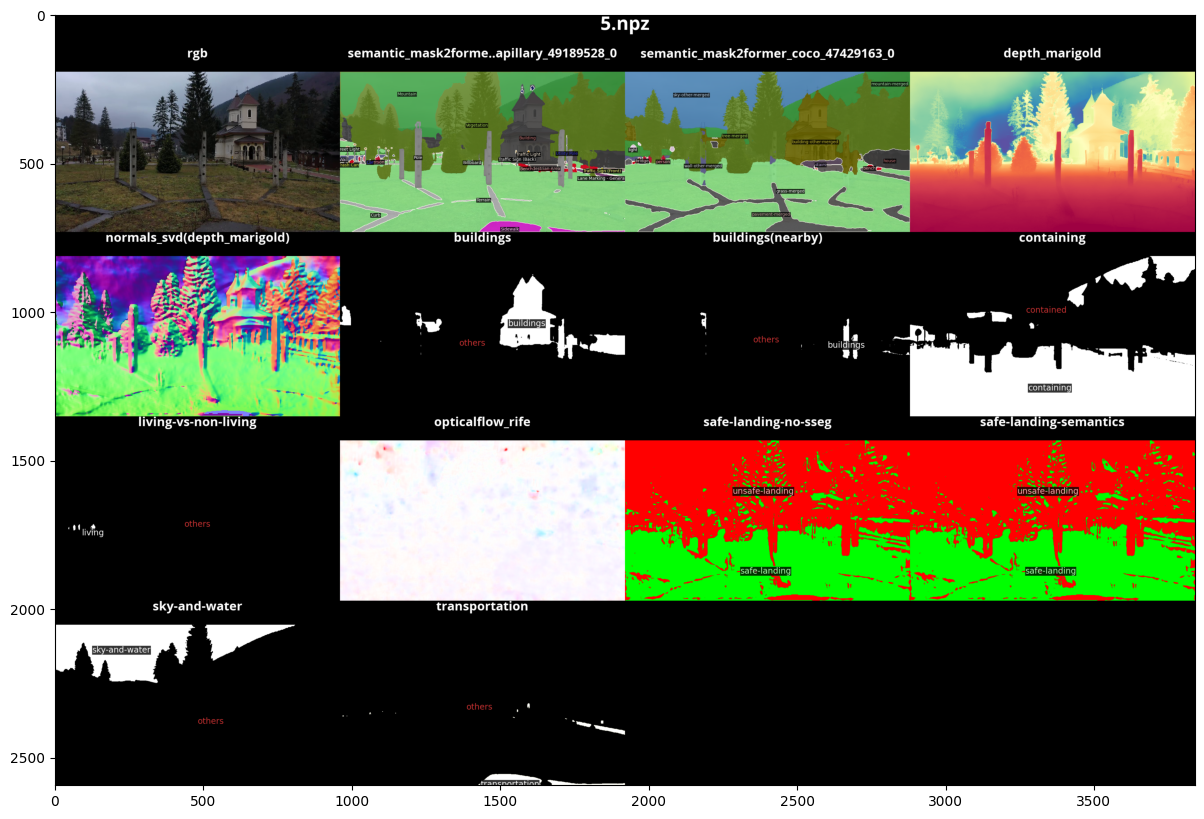

In [5]:
new_tasks = get_new_semantic_mapped_tasks()
for task_name in reader.task_names:
    if task_name not in orig_task_names:
        reader.remove_task(task_name)
for new_task in new_tasks.values():
    reader.add_task(new_task, overwrite=True)

print("== Random loaded item ==")
ixs = np.random.permutation(range(len(reader))).tolist()
for ix in ixs:
    data, name, _ = reader[ix] # get a random item
    plt.figure(figsize=(20, 10))
    plt.imshow(collage := plot_one(data, title=name, order=order, name_to_task=reader.name_to_task))
    plt.show()
    break

#### Storing the new experts-derived representations to the disk so next time they are not computed anymore.

We will 'commit' these changes to the dataset by running VRE with the `-I` flag on the semantic_mapper.py file, which
allows us to run the main VRE loop with external representations.

PS: this only works if we have access to the whole video (or a dir of all RGB frames) as `--frames 1 5 100` must
access them. In the future we may be able to run `data_path/rgb/npz` (or png) and use these as frames, but partially
accessible video is not yet supported (i.e. the frames 1, 5, 100 will map to indexes 0, 1, 2 for now).

In [6]:
assert data_path.suffix == ".mp4", f"This only works for video inputs, got {data_path}"
subprocess.run(args=["vre", str(data_path), "--cfg_path", str(cfg_path), "-o", str(vre_dir),
                     "--frames", "1", "5", "100",
                     "-I", f"{Path.cwd()}/semantic_mapper.py:get_new_semantic_mapped_tasks",
                     "--output_dir_exists_mode", "skip_computed"],
               env={**os.environ.copy(), **{"VRE_DEVICE": "cuda" if tr.cuda.is_available() else "cpu"}})

[2024-11-13T14:33:07 VRE-INFO] Building 'depth/marigold' (vre name: depth_marigold) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_coco_47429163_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Building 'semantic-segmentation/mask2former' (vre name: semantic_mask2former_mapillary_49189528_0) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Building 'optical-flow/rife' (vre name: opticalflow_rife) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Building 'default/rgb' (vre name: rgb) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Building 'normals/depth-svd' (vre name: normals_svd(depth_marigold)) (build_representations.py:build_representation_from_cfg:80)
[2024-11-13T14:33:08 VRE-INFO] Adding ['bu

          rgb  opticalflow_rife  ...  safe-landing-no-sseg  safe-landing-semantics
1    0.128405          0.188269  ...              0.463040                0.554630
5    0.128405          0.063808  ...              0.331936                0.456796
100  0.128405          0.221874  ...              0.542497                0.600522

[3 rows x 14 columns]


CompletedProcess(args=['vre', '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/../../resources/test_video.mp4', '--cfg_path', '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/cfg.yaml', '-o', '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/data_test_video.mp4', '--frames', '1', '5', '100', '-I', '/home/mihai/code/ml/video-representations-extractor/examples/semantic_mapper/semantic_mapper.py:get_new_semantic_mapped_tasks', '--output_dir_exists_mode', 'skip_computed'], returncode=0)

#### And now, in theory, the reader should be able to read the data from the disk without any computation!

[2024-11-13T14:33:25 VRE-INFO] Tasks used in this dataset: ['buildings', 'buildings(nearby)', 'containing', 'depth_marigold', 'living-vs-non-living', 'normals_svd(depth_marigold)', 'opticalflow_rife', 'rgb', 'safe-landing-no-sseg', 'safe-landing-semantics', 'semantic_mask2former_coco_47429163_0', 'semantic_mask2former_mapillary_49189528_0', 'sky-and-water', 'transportation'] (multitask_dataset.py:__init__:80)


== Random loaded item ==


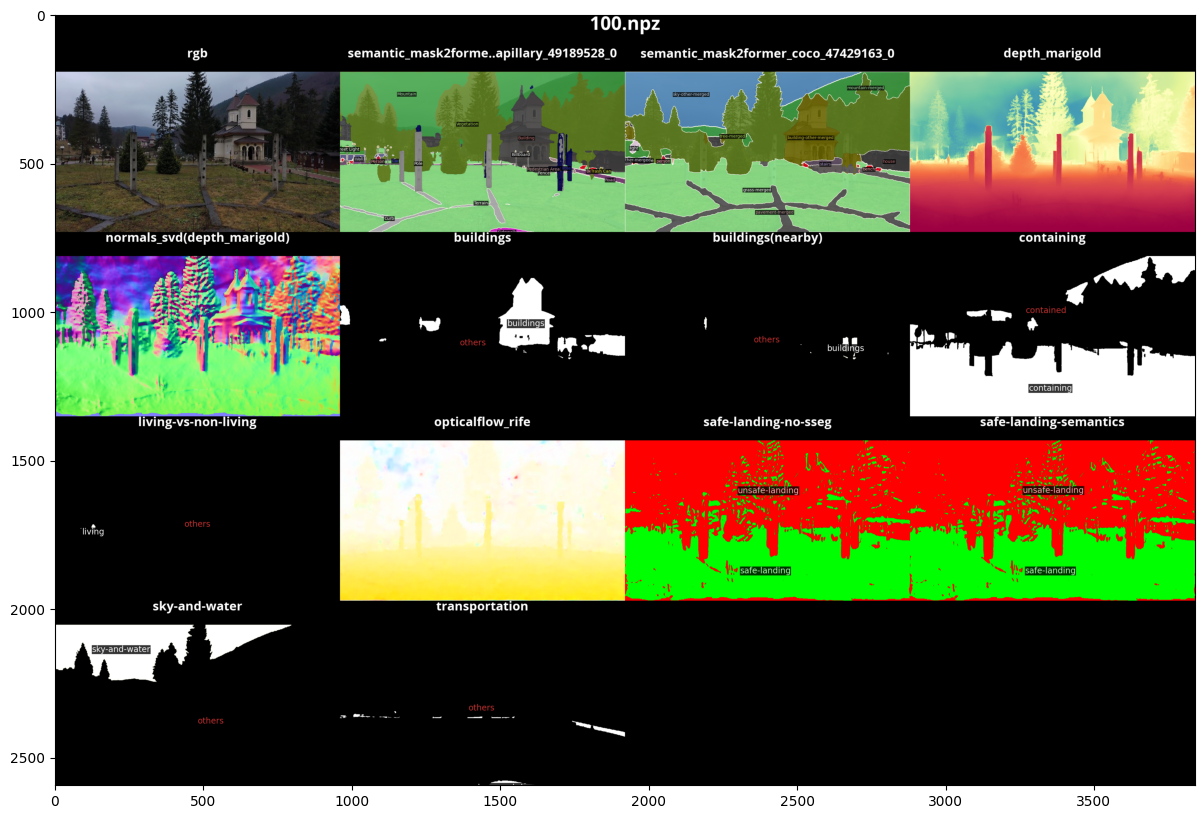

In [ ]:
assert data_path.suffix == ".mp4", f"This only works for video inputs, got {data_path}"

reader2 = MultiTaskDataset(vre_dir, task_names=[*task_names, *new_tasks.keys()],
                          task_types={**representations, **new_tasks}, handle_missing_data="fill_nan",
                          normalization="min_max", cache_task_stats=True, batch_size_stats=100)

print("== Random loaded item ==")
ixs = np.random.permutation(range(len(reader2))).tolist()
for ix in ixs:
    data, name, _ = reader2[ix] # get a random item
    plt.figure(figsize=(20, 10))
    plt.imshow(collage := plot_one(data, title=name, order=order, name_to_task=reader.name_to_task))
    plt.show()
    break
assert len(reader.files_per_repr["buildings"][0]) == 2 # 2 deps (old reader): m2f_coco and m2f_mapillary
assert isinstance(reader.files_per_repr["buildings"][0][0], Path) # 2 deps (old reader): m2f_coco and m2f_mapillary
assert isinstance(reader2.files_per_repr["buildings"][0], Path) # 1 dep (new reader after VRE): data is already on the disk